In [20]:
import os, glob, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

In [109]:
aria_FILE_PATH = '/Users/kaiyu/Downloads/y3s1 BT4241/ARIA Year End Charts'
billboard_FILE_PATH = '/Users/kaiyu/Downloads/y3s1 BT4241/Billboard Year End Charts'
columns_to_read = ['BPM', 'Dance', 'Energy', 'Happy']
chart_panel_df = pd.DataFrame(columns=['Country', 'Treat_Grp', 'Year', 'post_recession', 'BPM', 'Danceability', 'Energy', 'Happy'])

In [104]:
years = list(map(str, list(range(2004, 2014))))
li = ['Country Code'].extend(years)
gdp_stats_df = pd.read_csv('gdp_growth.csv', usecols=li)
gdp_stats_df.loc[(gdp_stats_df['Country Code'] == 'AUS') | (gdp_stats_df['Country Code'] == 'USA')]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
13,Australia,AUS,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,2.482330,1.294221,6.216180,6.980166,5.980140,...,2.759386,2.279592,2.878470,2.171545,-0.119591,2.111168,4.242386,3.441992,1.431113,NaN
251,United States,USA,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,2.565343,6.129637,4.357286,5.762747,6.498454,...,1.819451,2.457622,2.966505,2.583825,-2.163029,6.055053,2.512375,2.887556,2.796190,NaN


In [79]:
val = gdp_stats_df.at[13, '2010']
print(val)

2.21998026536549


In [110]:
# building the aria statistics first
all_files = os.listdir(aria_FILE_PATH)
for filename in all_files:
    year = re.split(r'[ .]', filename)[-2]
    curr_year_csv = pd.read_csv(os.path.join(aria_FILE_PATH, filename), usecols=columns_to_read)
    median_audio_features = curr_year_csv.mean()
    post_recession = 0 if int(year) < 2008 else 1
    new_row_df = pd.DataFrame({
        'Country': ['AUS'], 
        'Treat_Grp': [0],
        'Year': [int(year)], 
        'GDP_growth': gdp_stats_df.at[13, year],
        'post_recession': [post_recession], 
        'BPM': [median_audio_features['BPM']], 
        'Danceability': [median_audio_features['Dance']], 
        'Energy': [median_audio_features['Energy']],
        'Happy': [median_audio_features['Happy']]
    })
    chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)

/var/folders/yd/y56txp5d0t1_5b8nszp56my80000gn/T/ipykernel_21164/3018431633.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)


In [111]:
# building the billboard statistics now
all_files = os.listdir(billboard_FILE_PATH)
for filename in all_files:
    year = filename.split()[0]
    curr_year_csv = pd.read_csv(os.path.join(billboard_FILE_PATH, filename), usecols=columns_to_read)
    median_audio_features = curr_year_csv.mean()
    post_recession = 0 if int(year) < 2008 else 1
    new_row_df = pd.DataFrame({
        'Country': ['USA'], 
        'Treat_Grp': [1],
        'Year': [int(year)],
        'GDP_growth': gdp_stats_df.at[251, year], 
        'post_recession': [post_recession], 
        'BPM': [median_audio_features['BPM']], 
        'Danceability': [median_audio_features['Dance']], 
        'Energy': [median_audio_features['Energy']],
        'Happy': [median_audio_features['Happy']]
    })
    chart_panel_df = pd.concat([chart_panel_df, new_row_df], ignore_index=True)

TypeError: 'module' object is not callable

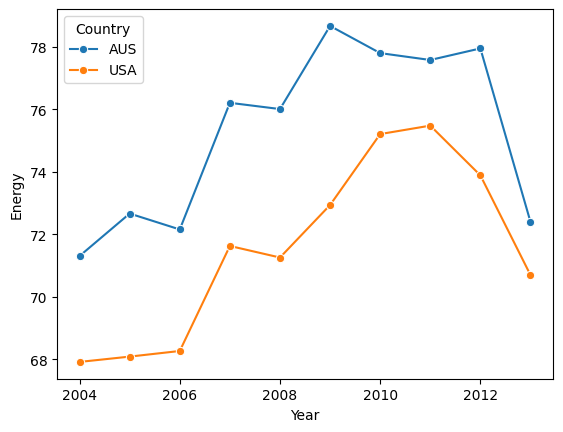

In [123]:
sns.lineplot(
    data=chart_panel_df,
    x='Year',
    y='Energy',
    hue='Country',
    marker='o'
)

plt.legend(title='Country')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [120]:
import statsmodels.formula.api as smf

# Create the interaction term for DiD
chart_panel_df["did"] = chart_panel_df["Treat_Grp"] * chart_panel_df["post_recession"]

# Run a fixed-effects (entity & time) DiD regression using OLS with dummy FE
# Country FE: C(country)
# Year FE: C(year)
model = smf.ols(
    formula="Happy ~ did + GDP_growth + C(Country) + C(Year)",
    data=chart_panel_df
).fit(cov_type="HC1")  # HC1 = robust (heteroskedasticity-consistent)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Happy   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     9.628
Date:                Tue, 11 Nov 2025   Prob (F-statistic):            0.00304
Time:                        03:42:54   Log-Likelihood:                -30.652
No. Observations:                  20   AIC:                             87.30
Df Residuals:                       7   BIC:                             100.2
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            60.9084      2.40